# Heart Rate Estimation using PPG (Random Forests regression)

The data has to be downloaded from [here](https://archive.ics.uci.edu/ml/datasets/PPG-DaLiA), unzipped into the current folder. Different folders for each individual has to be in the same directory as this notebook.

Follow the below code to load the data of each individual and process the PPG signal for all the individuals.

In [1]:
import pickle
import numpy as np
from math import floor
from tqdm import tqdm
lengths=[]
activities = []
ppg = []
lines = []
X = []
for i in tqdm(range(1,16)):
    st ='S'+str(i)+'/'+'S'+str(i)+'.pkl'
    with open(st, 'rb') as f:
        temp = pickle.load(f, encoding='latin1')
    ppg = temp['signal']['wrist']['BVP'].tolist()
    qppg =[]
    lengths.append(int(len(ppg)/128)-3)
    ac = temp['activity']
    tempac =[]
    for l in range(int(floor(ac.shape[0]/8))-3):
        activities.append(max(ac[l*8:(l+4)*8]))
    #print(len(activities),len(temp['label']))
    for p in range(int(len(ppg)/128)-3):
        t = np.zeros(512)
        k = 0
        for j in range(p*128,(4+p)*128):
            t[k] = ppg[j][0]
            k = k+1
        qppg.append(t)
    X.extend(qppg)
    lines.extend(temp['label'])
    #activities.extend(temp['activity'].tolist())
    #print(i)


100%|██████████| 15/15 [01:23<00:00,  5.53s/it]


In [2]:
import numpy as np
X=np.array(X)

In [3]:
Y = lines
Y = np.array(Y)

X and Y has the input and output data for training the model. The total data accounted for 64697 samples and each input sample is of size 512.

The input and output data is spiltted into train and test set using sklearn's train-test split

In [4]:
import scipy
import numpy as np
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.10, random_state=42)

We use RandomForestRegressor from sklearn's ensemble learning to train the model. We have used 300 trees to train the model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=300,random_state=0)
regressor.fit(X_train,y_train)

Using joblib dump the model, so that it can be loaded after and used for evaluation.

In [6]:
import joblib
joblib.dump(regressor,"random_forests_model")

Load the model using joblib.

In [7]:
regressor = joblib.load('random_forests_model')

Get all the accuracy metrics using the code below.

In [20]:
y_predict = regressor.predict(X)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Y, y_predict))  
print('MSE:', metrics.mean_squared_error(Y, y_predict))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y, y_predict)))
print('VarScore:',metrics.explained_variance_score(Y,y_predict))

MAE: 4.0768118926737955
MSE: 34.87809565174998
RMSE: 5.905767998469799
VarScore: 0.9330705174091323


Run the code below to plot a graph to see how far away the predictions are from the ground truth.

Text(0, 0.5, 'Predicted')

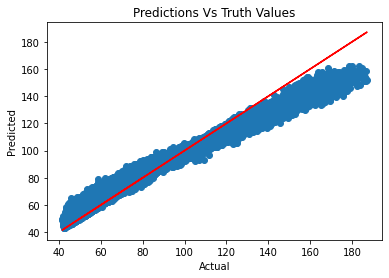

In [9]:
import matplotlib.pyplot as plt
plt.scatter(Y,y_predict)
plt.plot(Y,Y,color='red')
plt.title('Predictions Vs Truth Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
#plt.savefig('figures_final/predictions_rf.png')

Compare the predicted heart rate vs ground truth for all the individuals

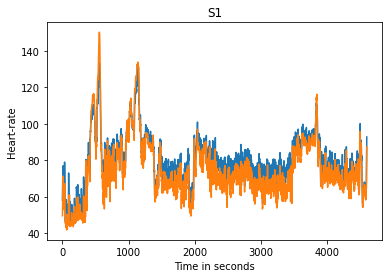

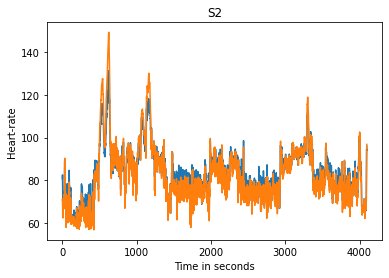

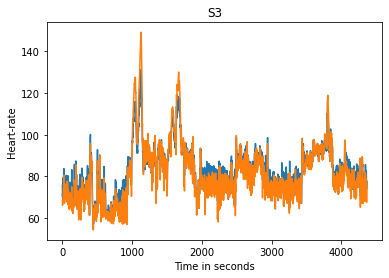

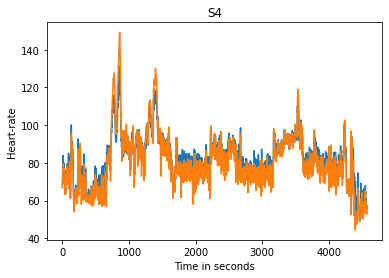

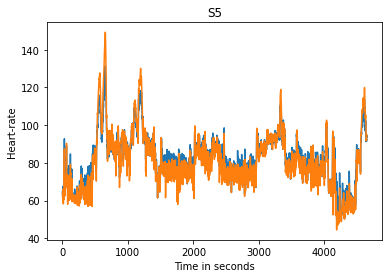

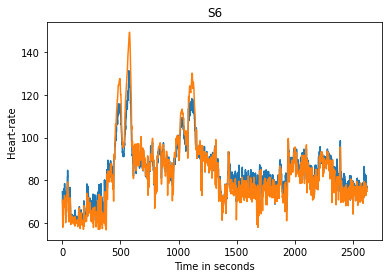

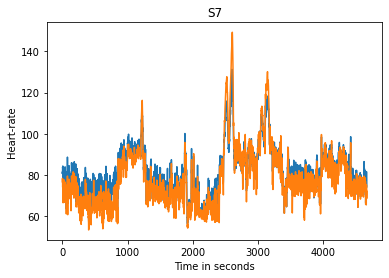

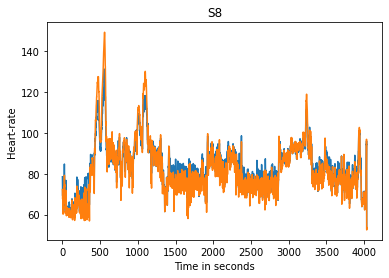

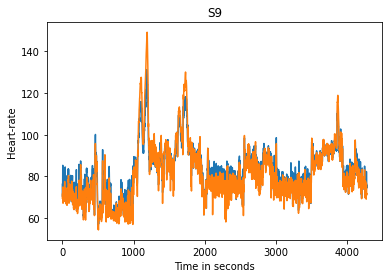

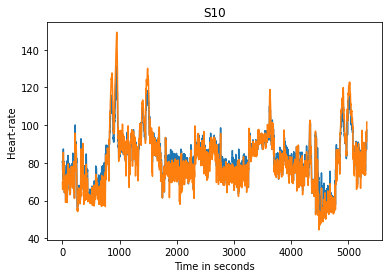

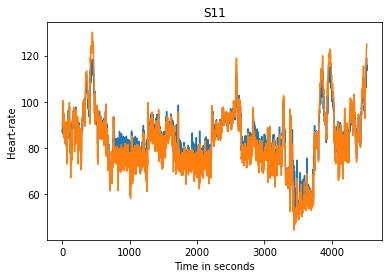

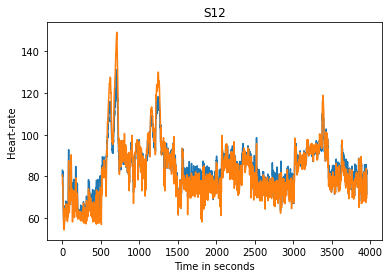

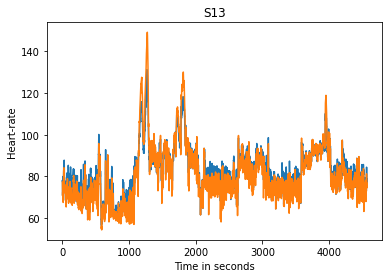

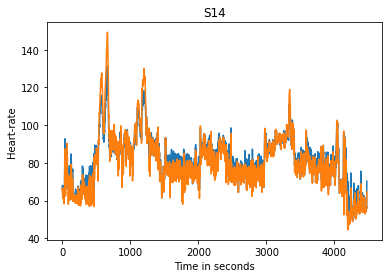

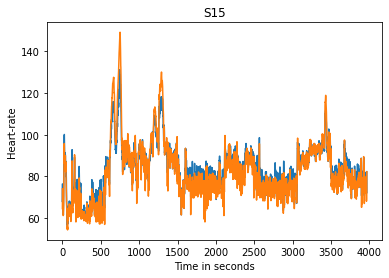

In [10]:
counter=0
for i in range(1,16):
    #plt.subplot(15,1,i)
    xaxis=range(lengths[i-1])
    yaxis=y_predict[counter:lengths[i-1]+counter]
    yaxis1=Y[counter:lengths[i-1]+counter]
    counter= lengths[i-1]
    plt.plot(xaxis,yaxis)
    plt.plot(xaxis,yaxis1)
    plt.title('S'+str(i))
    plt.xlabel('Time in seconds')
    plt.ylabel('Heart-rate')
    plt.show()
    #plt.savefig('figures_final/S'+str(i)+'_rf.png')
    #plt.clf()

Compare how fast the heart rate is changing by getting the difference between adjacent heart rates for both predicted and ground truth heart rates.

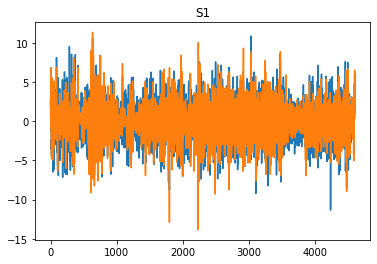

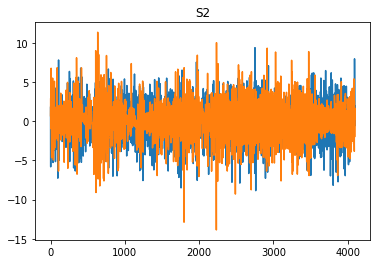

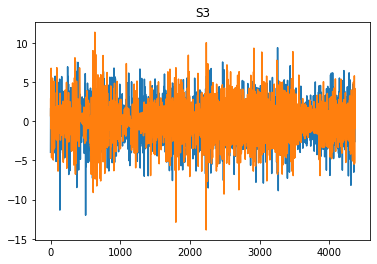

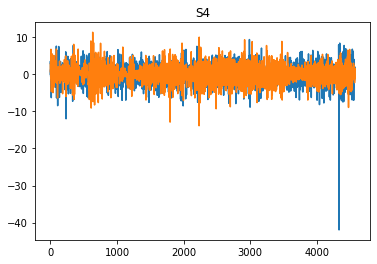

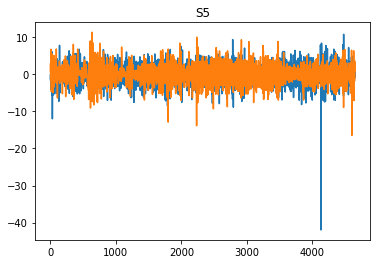

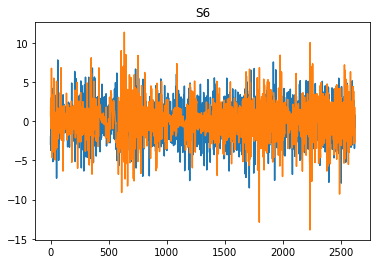

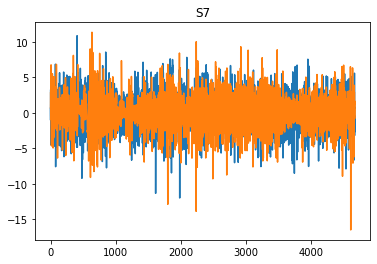

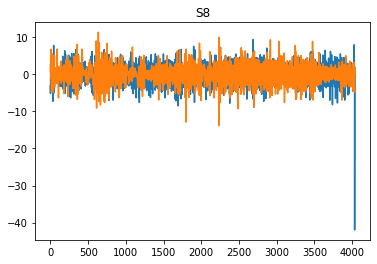

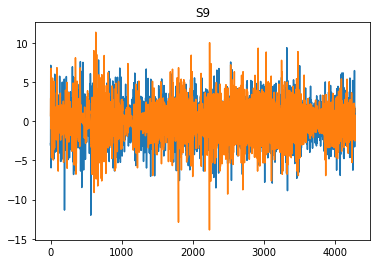

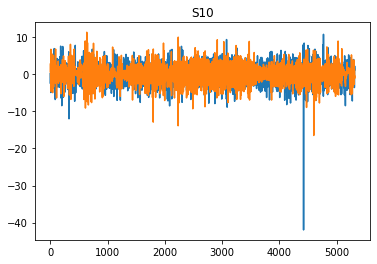

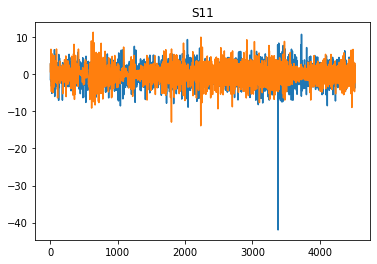

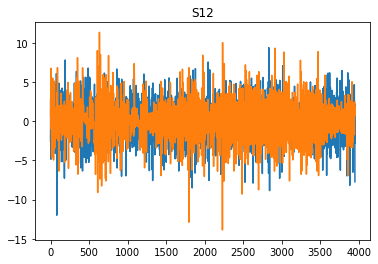

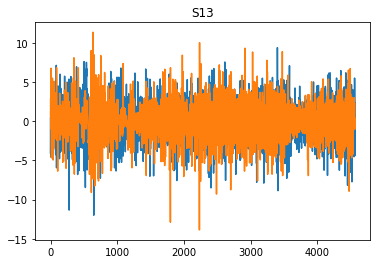

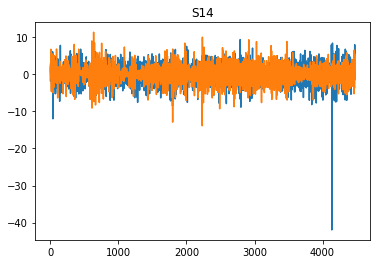

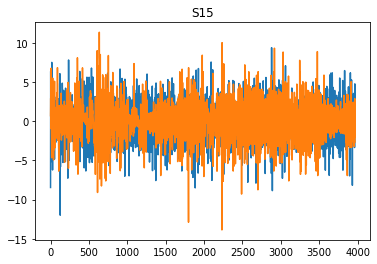

In [11]:
import matplotlib.pyplot as plt
counter =0
for i in range(1,16):
    #plt.subplot(15,1,i)
    xaxis=range(lengths[i-1]-1)
    yaxis = y_predict[counter:lengths[i-1]+counter]
    yaxis1=Y[counter:lengths[i-1]+counter]
    diff_list1 = []
    diff_list2 = []
    diff = 0
    for j in range(1,len(yaxis)):
        diff_list1.append(yaxis[j]-yaxis[j-1])
        diff_list2.append(Y[j]-Y[j-1])
    counter= lengths[i-1]
    plt.plot(xaxis,diff_list1)
    plt.plot(xaxis,diff_list2)
    plt.title('S'+str(i))
    plt.show()
    #plt.savefig('figures_final/S'+str(i)+'_diff_cnn.png')
    #plt.clf()

Check the accuracy for different thresholds by running the code below.

In [15]:
y_acc = []
x_acc = []
threshold = 1
while threshold < 10:
   counter =0
   for i in range(len(y_predict)):
       if abs(Y[i]-y_predict[i])<threshold:
           counter +=1
   y_acc.append((counter/len(y_predict))*100)
   x_acc.append(threshold)
   threshold += 0.1

Plot error margin vs accuracy over threshold values from 1 through 10.

Text(0, 0.5, 'Accuracy')

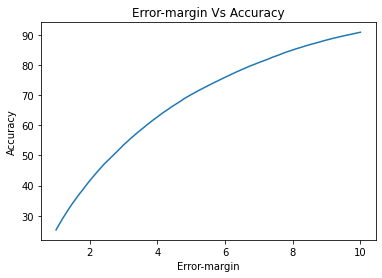

In [16]:
import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(10,5)) 
plt.plot(x_acc,y_acc)
plt.title('Error-margin Vs Accuracy')
plt.xlabel('Error-margin')
plt.ylabel('Accuracy')
#plt.savefig('figures_final/errorvsacc_graph_rf.png')

Find out and plot the error-margin vs accuracy for different activities for error-margin from 1 through 10.

In [17]:
acts = [[0 for i in range(10)] for j in range(9)]
 
for threshold in range(1,11):
   counter = 0
   positives = [0,0,0,0,0,0,0,0,0]
   totals = [0,0,0,0,0,0,0,0,0]
   for i in range(y_predict.shape[0]):
       if abs(Y[i]-y_predict[i])<threshold:
           positives[int(activities[i])]+=1
       totals[int(activities[i])]+=1
   for i in range(9):
       acts[i][threshold-1]=positives[i]/totals[i]

Text(0.5, 1.0, 'Error-margin Vs Accuracy for Different activities')

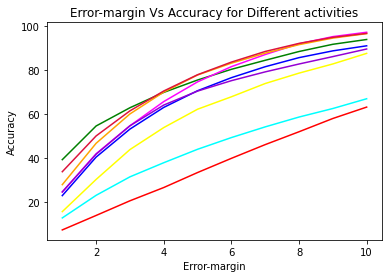

In [18]:
colr =['b','g','r','yellow','cyan','magenta','orange','darkviolet','crimson']
for i in range(9):
   plt.plot(range(1,11),[j*100 for j in acts[i]],color=colr[i])
plt.xlabel("Error-margin")
plt.ylabel("Accuracy")
plt.title("Error-margin Vs Accuracy for Different activities")
#plt.savefig('figures_final/act_rf.png')